In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_cosmology import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform2d import DWT2d
from utils import get_2dfilts, get_wavefun, low_to_high, dist
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_2dfilts, plot_2dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec

# load results

In [85]:
# wavelet params
waves = ["db5"]
mode = "zero"
J = 4

# result path
path = opj(os.getcwd(), "results")
dirs = [wave + "_saliency_warmstart_seed=1" for wave in waves]
# dirs = ["db3_saliency_warmstart_mode=per_seed=1"]
# dirs = ["sym4_saliency_warmstart_mode=per_seed=1"]

results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj(path, dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT2d(wave=waves[i], mode=mode, J=J, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))       
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [86]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)
R = len(lamL1wave_grid)
C = len(lamL1attr_grid)

# original wavelet
wt_o = DWT2d(wave='db5', mode=mode, J=J).to(device)

# collect results
dic = {'psi':{},
       'wt': {},
       'dist': {},
       'lamL1wave': {},
       'lamL1attr': {},
       'index': {}}

for r in range(R):
    for c in range(C):
        loc = (lamL1wave == lamL1wave_grid[r]) & (lamL1attr == lamL1attr_grid[c])
        if loc.sum() == 1: 
            loc = np.argwhere(loc).flatten()[0]
            dic['index'][(r,c)] = loc
            wt = mos[loc]
            _, psi, x = get_wavefun(wt)
            d = dist(wt, wt_o)

            dic['wt'][(r,c)] = wt
            dic['psi'][(r,c)] = psi
            dic['dist'][(r,c)] = d        
            dic['lamL1wave'][(r,c)] = lamL1wave_grid[r]
            dic['lamL1attr'][(r,c)] = lamL1attr_grid[c]


# plot wavelets

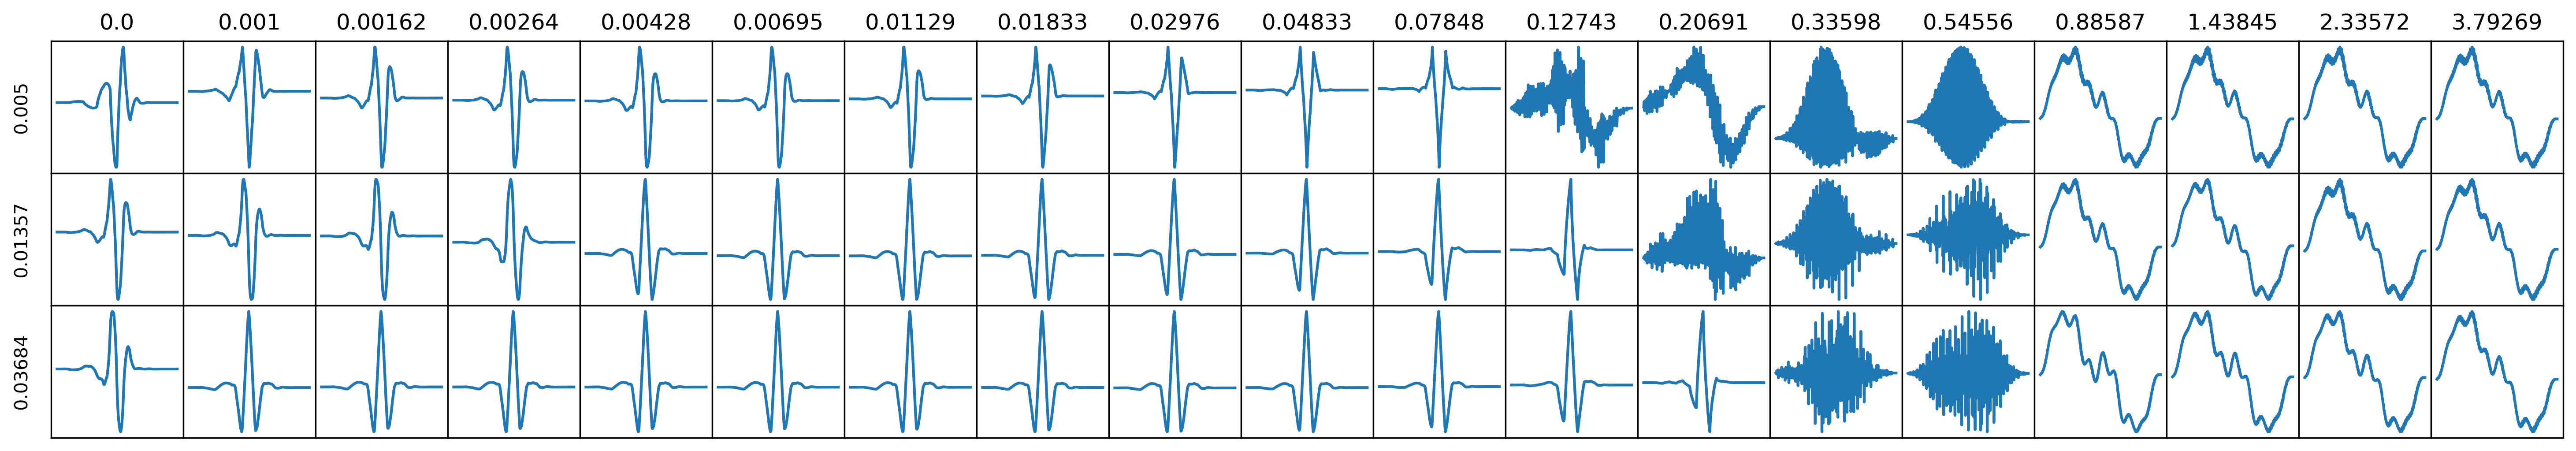

In [87]:
plt.figure(figsize=(C+1, R+1), dpi=300)
gs = gridspec.GridSpec(R, C,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(R+1), bottom=0.5/(R+1), 
         left=0.5/(C+1), right=1-0.5/(C+1))     

lamwaves = np.fromiter(dic['lamL1wave'].values(), dtype=float)
lamattrs = np.fromiter(dic['lamL1attr'].values(), dtype=float)
lamwaves = np.unique(lamwaves)
lamattrs = np.unique(lamattrs)
for r in range(R-1):
    for c in range(C):
        ax = plt.subplot(gs[r,c])
        ax.plot(x, dic['psi'][(r,c)]) 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,
            left=False,
            right=False,
            labelbottom=False) 
        if c == 0:
            plt.ylabel(str(lamwaves[r]))
        if r == 0:
            plt.title(str(lamattrs[c]))
plt.show()

Hyperparameter: lamL1wave=0.005000 lamL1attr=0.002640
Error: Recon=0.001522
Sparsity: Wave=97.191779
Interp: Saliency=112.069848 InputXGrade=0.805602
Wavelet loss: lSum=0.000000 hsum=0.000013 L2norm=0.000003 CMF=0.000123 Conv=0.000009


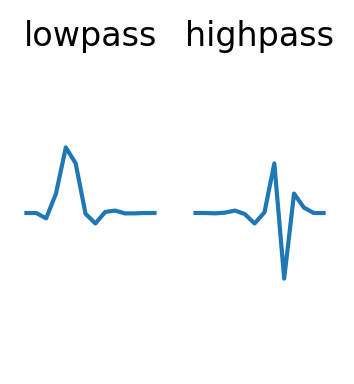

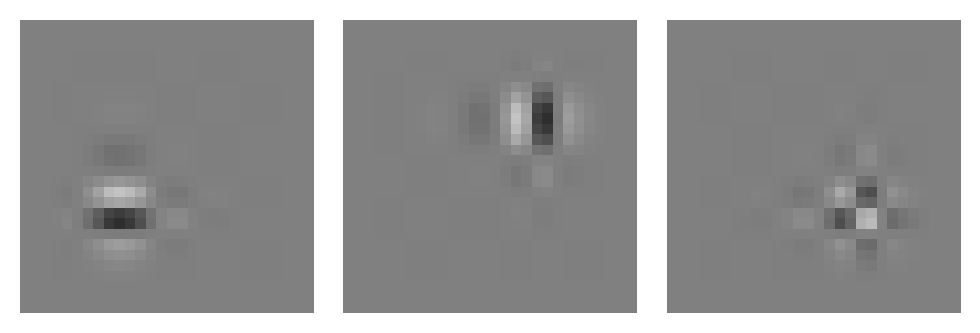

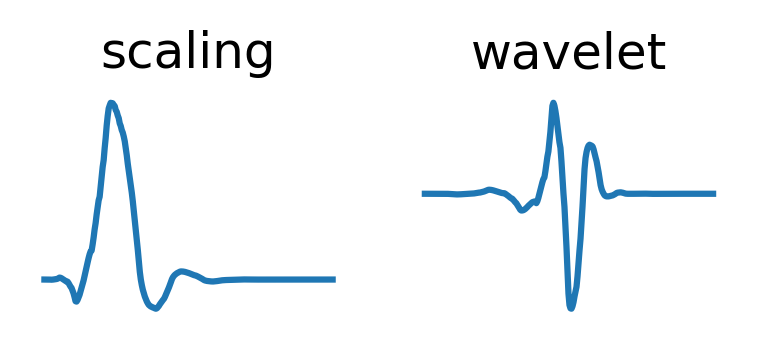

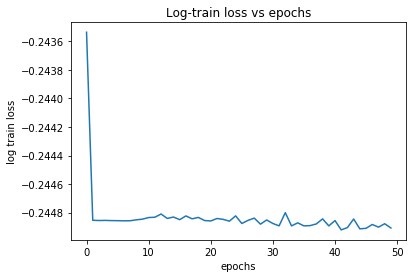

In [88]:
idx1 = 0
idx2 = 3
wt = mos[dic['index'][(idx1, idx2)]]
filt = get_2dfilts(wt)
phi, psi, x = get_wavefun(wt)

# print 
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][dic['index'][(idx1, idx2)]], res['lamL1attr'][dic['index'][(idx1, idx2)]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][dic['index'][(idx1, idx2)]]))
print('Sparsity: Wave={:.6f}'.format(res['L1wave_loss'][dic['index'][(idx1, idx2)]]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(res['L1saliency_loss'][dic['index'][(idx1, idx2)]], res['L1inputxgrad_loss'][dic['index'][(idx1, idx2)]]))
print('Wavelet loss: lSum={:.6f} hsum={:.6f} L2norm={:.6f} CMF={:.6f} Conv={:.6f}'.format(res['lsum_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['hsum_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['L2norm_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['CMF_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['conv_loss'][dic['index'][(idx1, idx2)]]))


plot_1dfilts(filt[0], is_title=True, figsize=(2,2))
plot_2dfilts(filt[1], figsize=(5,5))
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))

plt.plot(np.log(res['train_losses'][dic['index'][(idx1, idx2)]]))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [59]:
# #### plot original and reconstruction images
# train_loader, test_loader = get_dataloader(p.data_path, 
#                                            img_size=p.img_size[2],
#                                            split_train_test=True,
#                                            batch_size=p.batch_size)  
# data = iter(test_loader).next()[0].to(device)

# data_t = wt(data)
# recon = wt.inverse(data_t)

# print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))
# plot_2dreconstruct(data, recon)

In [22]:
# wavelet params
waves = ["db3"]
mode = "zero"
J = 4

# result path
path = opj(os.getcwd(), "results")
# dirs = [wave + "_saliency_warmstart_seed=1" for wave in waves]
# dirs = ["db3_saliency_warmstart_mode=per_seed=1"]
dirs = ["db3_saliency_warmstart_mode=zero_seed=1"]
# dirs = ["db4_saliency_warmstart_mode=per_seed=1"]

results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj(path, dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT2d(wave=waves[i], mode=mode, J=J, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))       
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [23]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)
R = len(lamL1wave_grid)
C = len(lamL1attr_grid)

# original wavelet
wt_o = DWT2d(wave='db5', mode=mode, J=J).to(device)

# collect results
dic = {'psi':{},
       'wt': {},
       'dist': {},
       'lamL1wave': {},
       'lamL1attr': {},
       'index': {}}

for r in range(R):
    for c in range(C):
        loc = (lamL1wave == lamL1wave_grid[r]) & (lamL1attr == lamL1attr_grid[c])
        if loc.sum() == 1: 
            loc = np.argwhere(loc).flatten()[0]
            dic['index'][(r,c)] = loc
            wt = mos[loc]
            _, psi, x = get_wavefun(wt)
            d = dist(wt, wt_o)

            dic['wt'][(r,c)] = wt
            dic['psi'][(r,c)] = psi
            dic['dist'][(r,c)] = d        
            dic['lamL1wave'][(r,c)] = lamL1wave_grid[r]
            dic['lamL1attr'][(r,c)] = lamL1attr_grid[c]


# plot wavelets

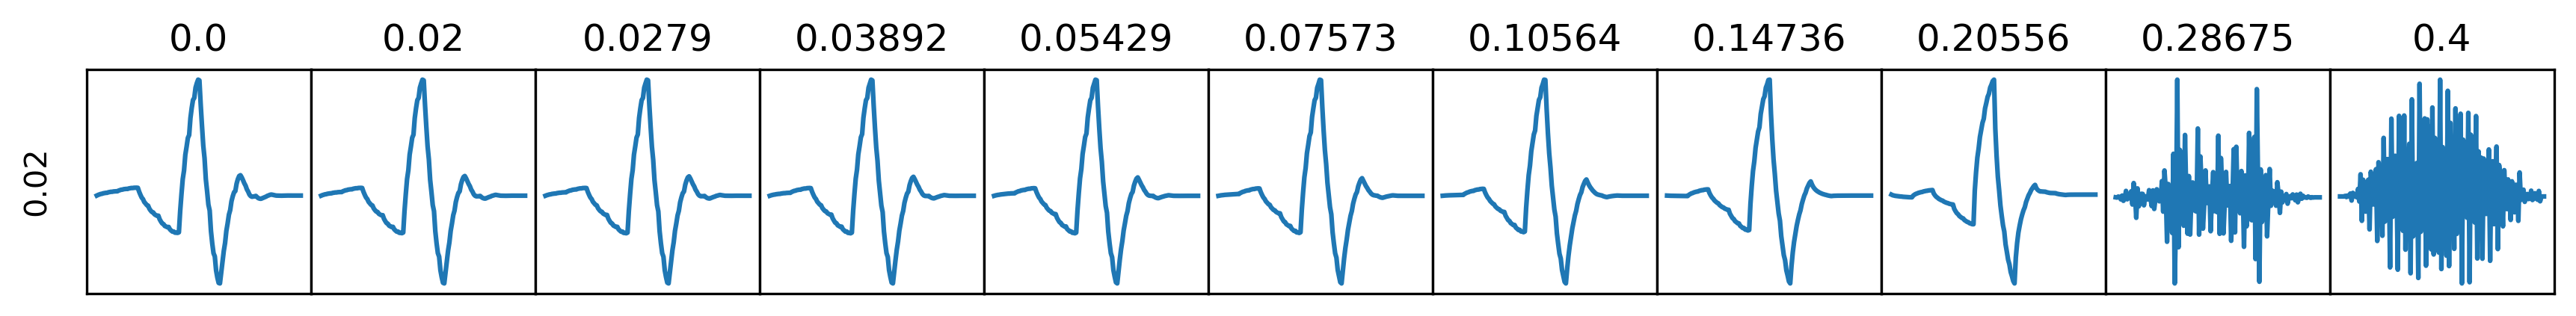

In [24]:
plt.figure(figsize=(C+1, R+1), dpi=300)
gs = gridspec.GridSpec(R, C,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(R+1), bottom=0.5/(R+1), 
         left=0.5/(C+1), right=1-0.5/(C+1))     

lamwaves = np.fromiter(dic['lamL1wave'].values(), dtype=float)
lamattrs = np.fromiter(dic['lamL1attr'].values(), dtype=float)
lamwaves = np.unique(lamwaves)
lamattrs = np.unique(lamattrs)
for r in range(R):
    for c in range(C):
        ax = plt.subplot(gs[r,c])
        ax.plot(x, dic['psi'][(r,c)]) 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,
            left=False,
            right=False,
            labelbottom=False) 
        if c == 0:
            plt.ylabel(str(lamwaves[r]))
        if r == 0:
            plt.title(str(lamattrs[c]))
plt.show()

Hyperparameter: lamL1wave=0.020000 lamL1attr=0.147360
Error: Recon=0.309050
Sparsity: Wave=66.551087
Interp: Saliency=76.584756 InputXGrade=0.542922
Wavelet loss: lSum=0.000004 hsum=0.000050 L2norm=0.000608 CMF=0.011828 Conv=0.003150


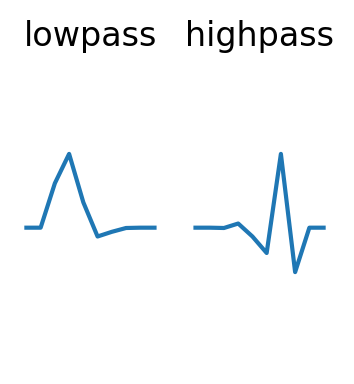

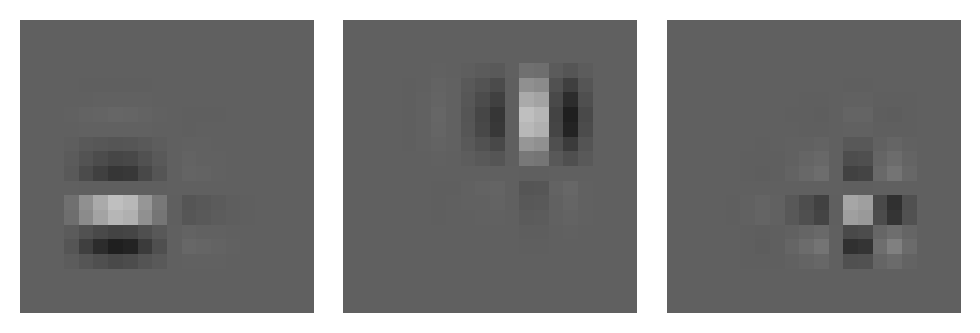

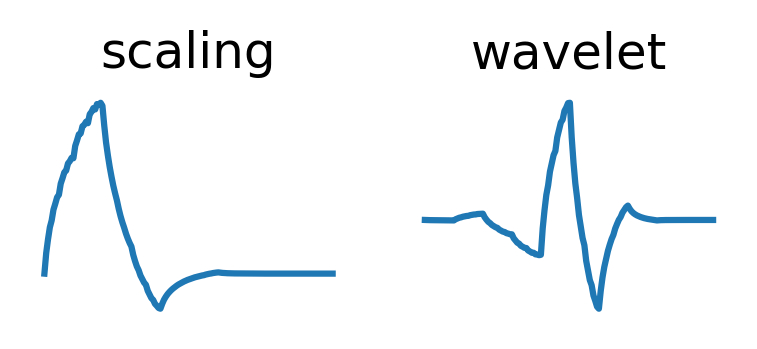

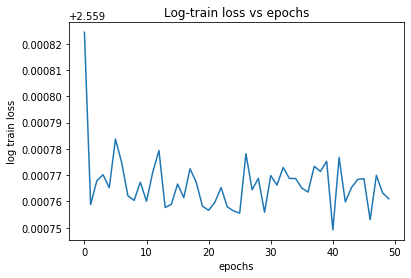

In [29]:
idx1 = 0
idx2 = 7
wt = mos[dic['index'][(idx1, idx2)]]
filt = get_2dfilts(wt)
phi, psi, x = get_wavefun(wt)

# print 
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][dic['index'][(idx1, idx2)]], res['lamL1attr'][dic['index'][(idx1, idx2)]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][dic['index'][(idx1, idx2)]]))
print('Sparsity: Wave={:.6f}'.format(res['L1wave_loss'][dic['index'][(idx1, idx2)]]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(res['L1saliency_loss'][dic['index'][(idx1, idx2)]], res['L1inputxgrad_loss'][dic['index'][(idx1, idx2)]]))
print('Wavelet loss: lSum={:.6f} hsum={:.6f} L2norm={:.6f} CMF={:.6f} Conv={:.6f}'.format(res['lsum_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['hsum_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['L2norm_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['CMF_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['conv_loss'][dic['index'][(idx1, idx2)]]))


plot_1dfilts(filt[0], is_title=True, figsize=(2,2))
plot_2dfilts(filt[1], figsize=(5,5))
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))

plt.plot(np.log(res['train_losses'][dic['index'][(idx1, idx2)]]))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [34]:
# wavelet params
waves = ["db3"]
mode = "zero"
J = 4

# result path
path = opj(os.getcwd(), "results")
# dirs = [wave + "_saliency_warmstart_seed=1" for wave in waves]
# dirs = ["db3_saliency_warmstart_mode=per_seed=1_old2"]
dirs = ["db3_saliency_warmstart_mode=per_seed=1"]
# dirs = ["db4_saliency_warmstart_mode=per_seed=1"]

results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj(path, dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT2d(wave=waves[i], mode=mode, J=J, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))       
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [35]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)
R = len(lamL1wave_grid)
C = len(lamL1attr_grid)

# original wavelet
wt_o = DWT2d(wave='db5', mode=mode, J=J).to(device)

# collect results
dic = {'psi':{},
       'wt': {},
       'dist': {},
       'lamL1wave': {},
       'lamL1attr': {},
       'index': {}}

for r in range(R):
    for c in range(C):
        loc = (lamL1wave == lamL1wave_grid[r]) & (lamL1attr == lamL1attr_grid[c])
        if loc.sum() == 1: 
            loc = np.argwhere(loc).flatten()[0]
            dic['index'][(r,c)] = loc
            wt = mos[loc]
            _, psi, x = get_wavefun(wt)
            d = dist(wt, wt_o)

            dic['wt'][(r,c)] = wt
            dic['psi'][(r,c)] = psi
            dic['dist'][(r,c)] = d        
            dic['lamL1wave'][(r,c)] = lamL1wave_grid[r]
            dic['lamL1attr'][(r,c)] = lamL1attr_grid[c]


# plot wavelets

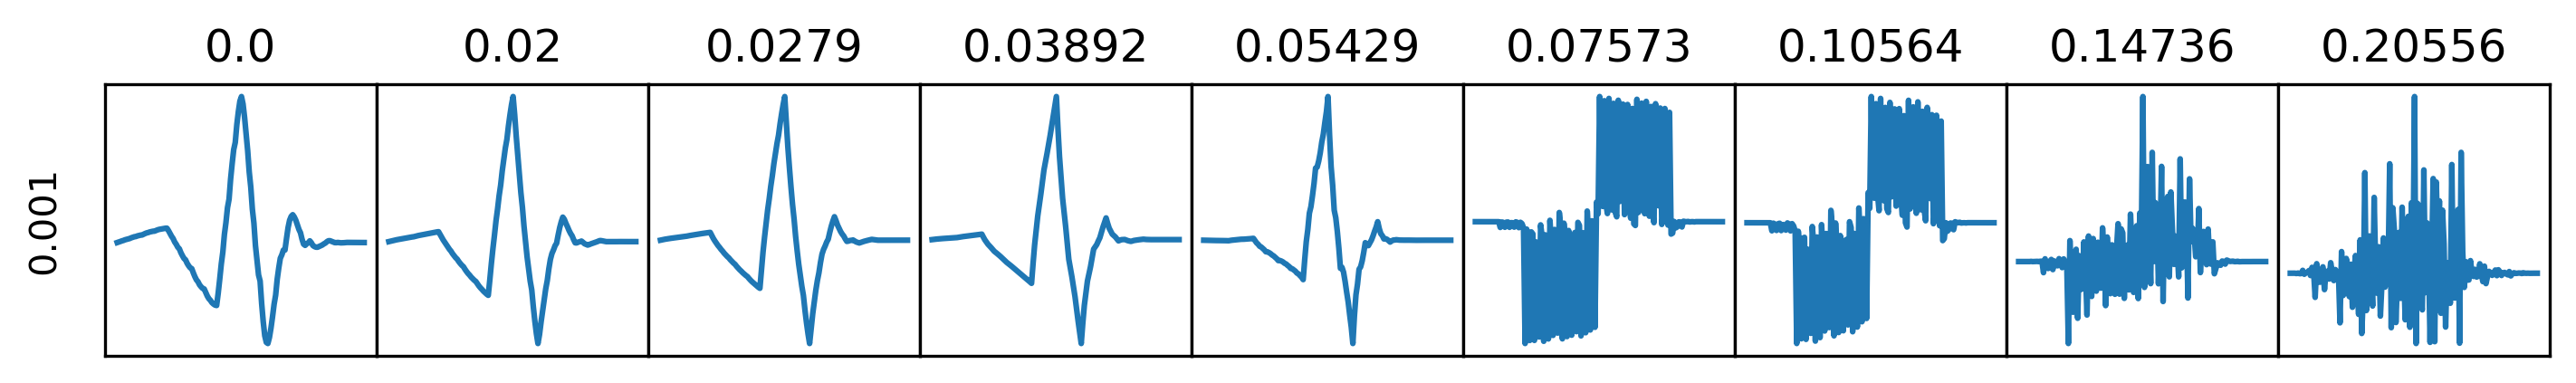

In [36]:
plt.figure(figsize=(C+1, R+1), dpi=300)
gs = gridspec.GridSpec(R, C,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(R+1), bottom=0.5/(R+1), 
         left=0.5/(C+1), right=1-0.5/(C+1))     

lamwaves = np.fromiter(dic['lamL1wave'].values(), dtype=float)
lamattrs = np.fromiter(dic['lamL1attr'].values(), dtype=float)
lamwaves = np.unique(lamwaves)
lamattrs = np.unique(lamattrs)
for r in range(R):
    for c in range(C):
        ax = plt.subplot(gs[r,c])
        ax.plot(x, dic['psi'][(r,c)]) 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,
            left=False,
            right=False,
            labelbottom=False) 
        if c == 0:
            plt.ylabel(str(lamwaves[r]))
        if r == 0:
            plt.title(str(lamattrs[c]))
plt.show()

Hyperparameter: lamL1wave=0.001000 lamL1attr=0.054290
Error: Recon=0.033687
Sparsity: Wave=68.760615
Interp: Saliency=78.870606 InputXGrade=0.610080
Wavelet loss: lSum=0.000000 hsum=0.000013 L2norm=0.000063 CMF=0.001166 Conv=0.000293


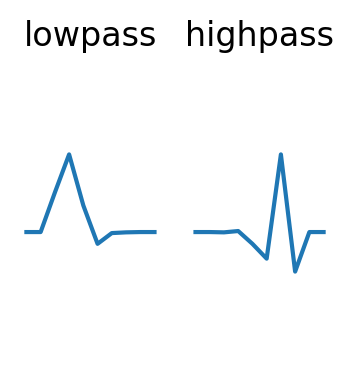

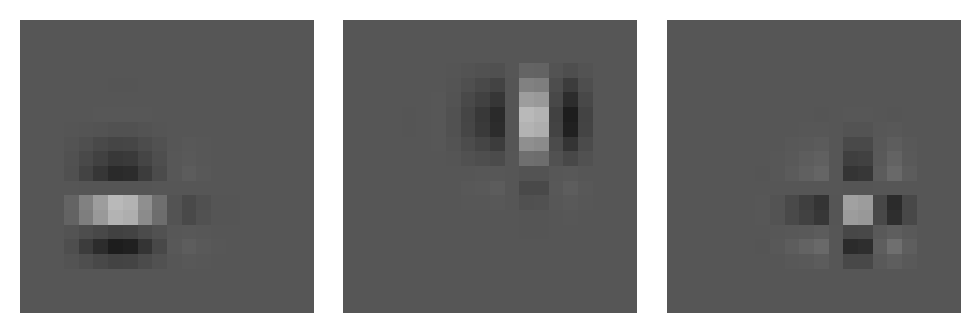

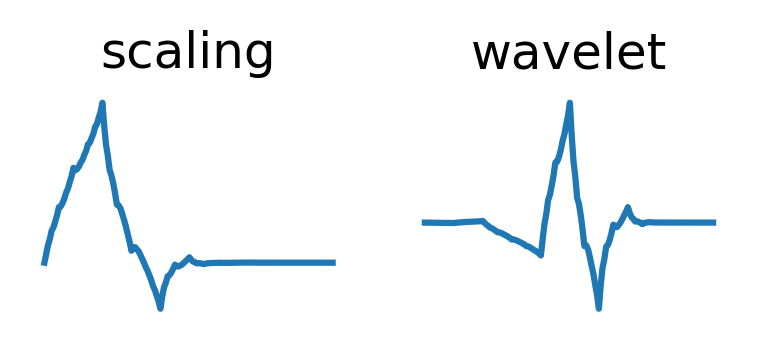

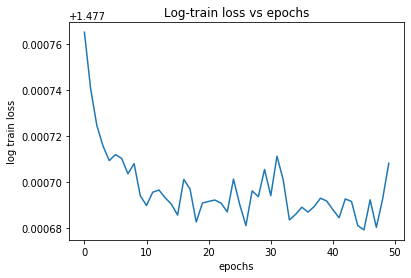

In [43]:
idx1 = 0
idx2 = 4
wt = mos[dic['index'][(idx1, idx2)]]
filt = get_2dfilts(wt)
phi, psi, x = get_wavefun(wt)

# print 
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][dic['index'][(idx1, idx2)]], res['lamL1attr'][dic['index'][(idx1, idx2)]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][dic['index'][(idx1, idx2)]]))
print('Sparsity: Wave={:.6f}'.format(res['L1wave_loss'][dic['index'][(idx1, idx2)]]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(res['L1saliency_loss'][dic['index'][(idx1, idx2)]], res['L1inputxgrad_loss'][dic['index'][(idx1, idx2)]]))
print('Wavelet loss: lSum={:.6f} hsum={:.6f} L2norm={:.6f} CMF={:.6f} Conv={:.6f}'.format(res['lsum_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['hsum_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['L2norm_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['CMF_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['conv_loss'][dic['index'][(idx1, idx2)]]))


plot_1dfilts(filt[0], is_title=True, figsize=(2,2))
plot_2dfilts(filt[1], figsize=(5,5))
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))

plt.plot(np.log(res['train_losses'][dic['index'][(idx1, idx2)]]))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()